In [83]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import pickle as pkl
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import utils

## Data Loading

In [9]:
DATASET_PATH = '../ADE20K_2021_17_01/'
index_file = 'index_ade20k.pkl'
with open('{}/{}'.format(DATASET_PATH, index_file), 'rb') as f:
    index_ade20k = pkl.load(f)

In [65]:
objects_mat = index_ade20k['objectPresence']

In [66]:
# Find 150 most common object IDs and non-common object IDs
total_object_counts = np.sum(objects_mat, axis=1)
object_count_ids = np.argsort(total_object_counts)[::-1]
most_common_obj_ids = object_count_ids[:150]
irrelevant_obj_ids = object_count_ids[150:]

In [67]:
most_common_obj_ids

array([3049, 2977, 1830, 2854,  311,  773,  470,  400, 1909,  975, 2419,
       1450, 3054, 1734,  446, 2683,  349, 1432, 1179, 1394, 2379,  688,
        235, 2130, 2376,  788, 1447, 2615,  686, 2310, 1379,  265, 1124,
       3034, 1745, 1609,  837,  248,   53, 2137, 2328, 2271,   82, 1205,
       1980,  579, 2508, 1237, 1563,   56,  977,  906,  164, 2931, 2275,
       1868,  580, 1097, 1935, 1918, 2472, 2242,  100, 2981, 2121,  135,
         85, 2177, 2116,  883, 2052, 1427,  258, 2387,  180, 1430, 2119,
       2813, 1212, 1275, 1743, 1438, 3086, 2699,   94, 2050,  723, 2529,
        145, 2263,  894, 1973, 2577, 2820,  570,  981, 1211, 2835, 2585,
       1624, 1348,   76, 1328, 2369, 1929, 2367, 2154,  529, 2678,   41,
         63, 3056, 2422,  222,  953, 1614,  377, 2993, 1755, 1787,  912,
       2118,  102,  782,  479, 1023, 2675,  211,  119, 2927, 1001, 2272,
        917, 2732, 1032,  136, 2530, 2849, 1968, 2340,  729, 2249, 1429,
       2345, 2832, 2900, 2879,  775, 1085,  319])

In [69]:
# Find image IDs where no irrelevant objects appear
irrelevant_obj_counts = np.sum(objects_mat[irrelevant_obj_ids], axis=0)
good_image_ids = np.argwhere(irrelevant_obj_counts == 0).flatten()

In [71]:
good_image_ids

array([   41,    74,   105, ..., 27550, 27556, 27573])

In [77]:
# Only common objects included
common_objects_mat = objects_mat[np.ix_(most_common_obj_ids, good_image_ids)]

## EXAMPLE TEST

41
../ADE20K_2021_17_01/images/ADE/training/home_or_hotel/bathroom/ADE_train_00000042.jpg
(536, 402, 3)
74
../ADE20K_2021_17_01/images/ADE/training/home_or_hotel/bathroom/ADE_train_00000075.jpg
(1400, 1772, 3)
105
../ADE20K_2021_17_01/images/ADE/training/home_or_hotel/bathroom/ADE_train_00000106.jpg
(1652, 2200, 3)
191
../ADE20K_2021_17_01/images/ADE/training/home_or_hotel/bedroom/ADE_train_00000192.jpg
(256, 256, 3)


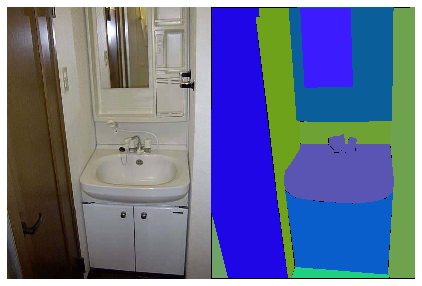

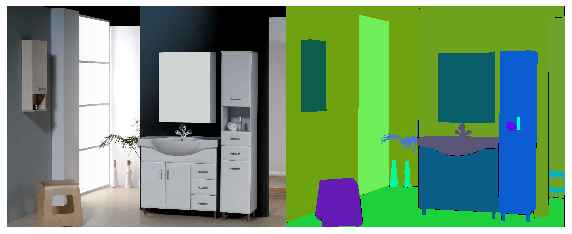

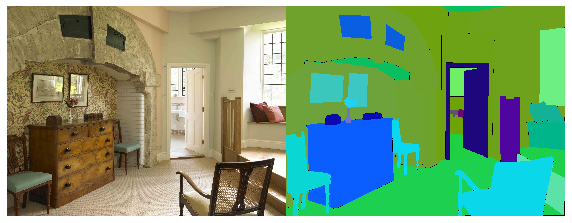

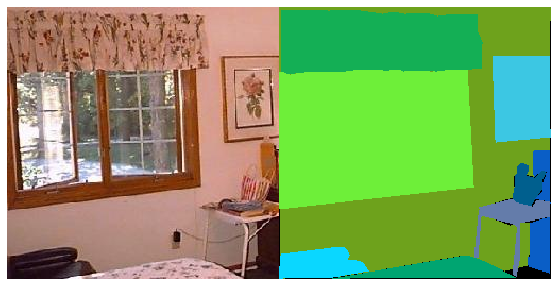

In [99]:
for i in good_image_ids[:4]:
    print(i)
    full_file_name = '../{}/{}'.format(index_ade20k['folder'][i], index_ade20k['filename'][i])
    print(full_file_name)
    info = utils.loadAde20K(full_file_name)
    img = cv2.imread(info['img_name'])[:,:,::-1]
    seg = cv2.imread(info['segm_name'])[:,:,::-1]
# #     seg_mask = seg.copy()

# #     The 0 index in seg_mask corresponds to background (not annotated) pixels
# #     seg_mask[info['class_mask'] != obj_id+1] *= 0
    plt.figure(figsize=(10,5))

    plt.imshow(np.concatenate([img, seg], 1))
    plt.axis('off')
    print(img.shape)
    

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, image_ids, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_ids = image_ids
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
training_data = torch.utils.data.Dataset()

In [ ]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    # For now, we resize/crop the image to the correct input size for our network,
    # then convert it to a [C,H,W] tensor, then normalize it to values with a given mean/stdev. These normalization constants
    # are derived from aggregating lots of data and happen to produce better results.
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in data_transforms.keys()}
    # Create training and validation dataloaders
    # Never shuffle the test set
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict

## Load model

In [96]:
model = models.segmentation.fcn_resnet50(pretrained=False, num_classes=150)

In [92]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
for i in range(10):
    running_loss = 0
    for images, labels in trainloader:

        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(i+1, running_loss/len(trainloader)))

## Training

In [ ]:
import time
def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
#     model.cuda()
    train_loss, valid_loss = [], []
    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 10 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()